In [26]:
import anndata as ad
import scvelo as scv
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import matplotlib

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80,color_map="viridis")

scanpy==1.4.4 anndata==0.6.22.post1 umap==0.3.9 numpy==1.16.4 scipy==1.3.0 pandas==0.25.0 scikit-learn==0.21.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [120]:
adata = ad.read_h5ad('mergedAdata.h5ad')
adata

AnnData object with n_obs × n_vars = 14108 × 31053 
    obs: 'batch', 'cellLabel'
    var: 'geneName', 'geneId'

In [121]:
adata.var_names_make_unique()

In [122]:
adata.var = adata.var.set_index('geneName')

### Remove negative cells and doublets

In [123]:
adata = ad.AnnData(adata[~adata.obs['cellLabel'].values.isin(['Negative'])])
adata = ad.AnnData(adata[~adata.obs['cellLabel'].values.isin(['Doublet'])])

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Split labels into different categories

In [125]:
set(adata.obs['cellLabel'])

{'4T1-D1',
 '4T1-D3',
 '4T1-D5',
 'Mouse1_Collagen_D1',
 'Mouse1_Collagen_D3',
 'Mouse1_Collagen_D5',
 'Mouse1_Matrigel_D1',
 'Mouse1_Matrigel_D3',
 'Mouse1_Matrigel_D5',
 'Mouse2_Collagen_D1',
 'Mouse2_Collagen_D3',
 'Mouse2_Collagen_D5',
 'Mouse2_Matrigel_D1',
 'Mouse2_Matrigel_D3',
 'Mouse2_Matrigel_D5',
 'Mouse3_Collagen_D1',
 'Mouse3_Collagen_D3',
 'Mouse3_Collagen_D5',
 'Mouse3_Matrigel_D1',
 'Mouse3_Matrigel_D3',
 'Mouse3_Matrigel_D5',
 'Mouse4_Collagen_D1',
 'Mouse4_Collagen_D3',
 'Mouse4_Matrigel_D1',
 'Mouse4_Matrigel_D3'}

In [126]:
days = list(adata.obs['cellLabel'].values)
for i,cl in enumerate(days):
    days[i] = cl[-2:]

In [127]:
mouse = list(adata.obs['cellLabel'].values)
media = list(adata.obs['cellLabel'].values)
for i,cl in enumerate(mouse):
    if 'Mouse' in cl:
        splt = cl.split('_')
        mouse[i] = splt[0]
        media[i] = splt[1]
    else:
        mouse[i] = 'cell line'
        media[i] = 'NA'
print(set(mouse))
set(media)

{'Mouse4', 'Mouse2', 'Mouse3', 'Mouse1', 'cell line'}


{'Collagen', 'Matrigel', 'NA'}

In [128]:
# assign new lables
adata.obs['mouse'] = mouse
adata.obs['media'] = media
adata.obs['day'] = days

adata.obs.head()

,batch,cellLabel,mouse,media,day
index,,,,,
AAACCCACACCATAAC-0-0,0,Mouse1_Collagen_D1,Mouse1,Collagen,D1
AAACCCATCGTCGGGT-0-0,0,Mouse3_Matrigel_D1,Mouse3,Matrigel,D1
AAACGAAAGTAGTGCG-0-0,0,Mouse2_Matrigel_D1,Mouse2,Matrigel,D1
AAACGCTCACCGTGGT-0-0,0,Mouse1_Matrigel_D1,Mouse1,Matrigel,D1
AAACGCTGTGACTATC-0-0,0,Mouse1_Matrigel_D1,Mouse1,Matrigel,D1


In [129]:
import collections
print(collections.Counter(mouse))
print(collections.Counter(days))
print(collections.Counter(media))

Counter({'Mouse2': 2900, 'Mouse3': 2670, 'Mouse1': 1675, 'Mouse4': 1663, 'cell line': 331})
Counter({'D3': 3936, 'D1': 3749, 'D5': 1554})
Counter({'Collagen': 5776, 'Matrigel': 3132, 'NA': 331})


In [132]:
#Save labelled data
adata.write_h5ad('labelledAdata.h5ad')

In [131]:
adata

AnnData object with n_obs × n_vars = 9239 × 31053 
    obs: 'batch', 'cellLabel', 'mouse', 'media', 'day'
    var: 'geneId'

In [14]:
scp.io.mmwrite('data/dataMatrix.mtx',adata.X)
adata.obs.to_csv('data/obs.csv')
adata.var.to_csv('data/var.csv')

In [157]:
adata = ad.read_h5ad('labelledAdata.h5ad')
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 9239 × 31053 
    obs: 'batch', 'cellLabel', 'mouse', 'media', 'day'
    var: 'geneId'

In [158]:
adata.var_names_make_unique()

## Quality Check

In [165]:
# Remove cells with less than 200 genes
sc.pp.filter_cells(adata, min_genes=200)
# Remove genes present in less than 3 cells
sc.pp.filter_genes(adata, min_cells=3)

filtered out 341 cells that haveless than 200 genes expressed
filtered out 10448 genes that are detectedin less than 3 cells


normalizing by total count per cell
    finished (0:00:03): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


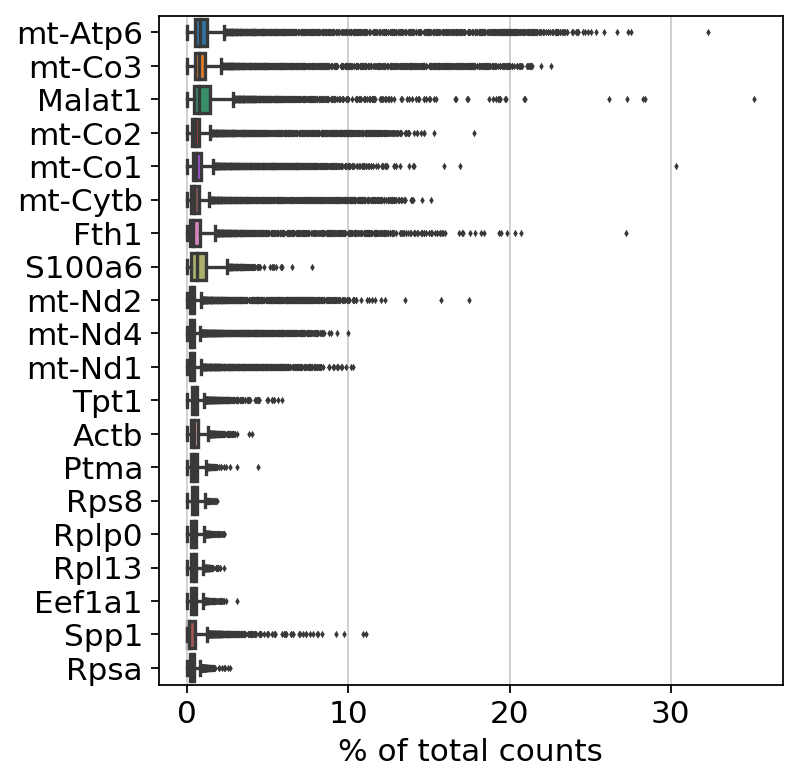

In [166]:
# this gives the top genes with highest mean expression in cells
sc.pl.highest_expr_genes(adata, n_top=20, )

Here, 8/20 genes are mitocondrial genes which suggests that the normal RNA has escaped in many cells and we see high mito genes content

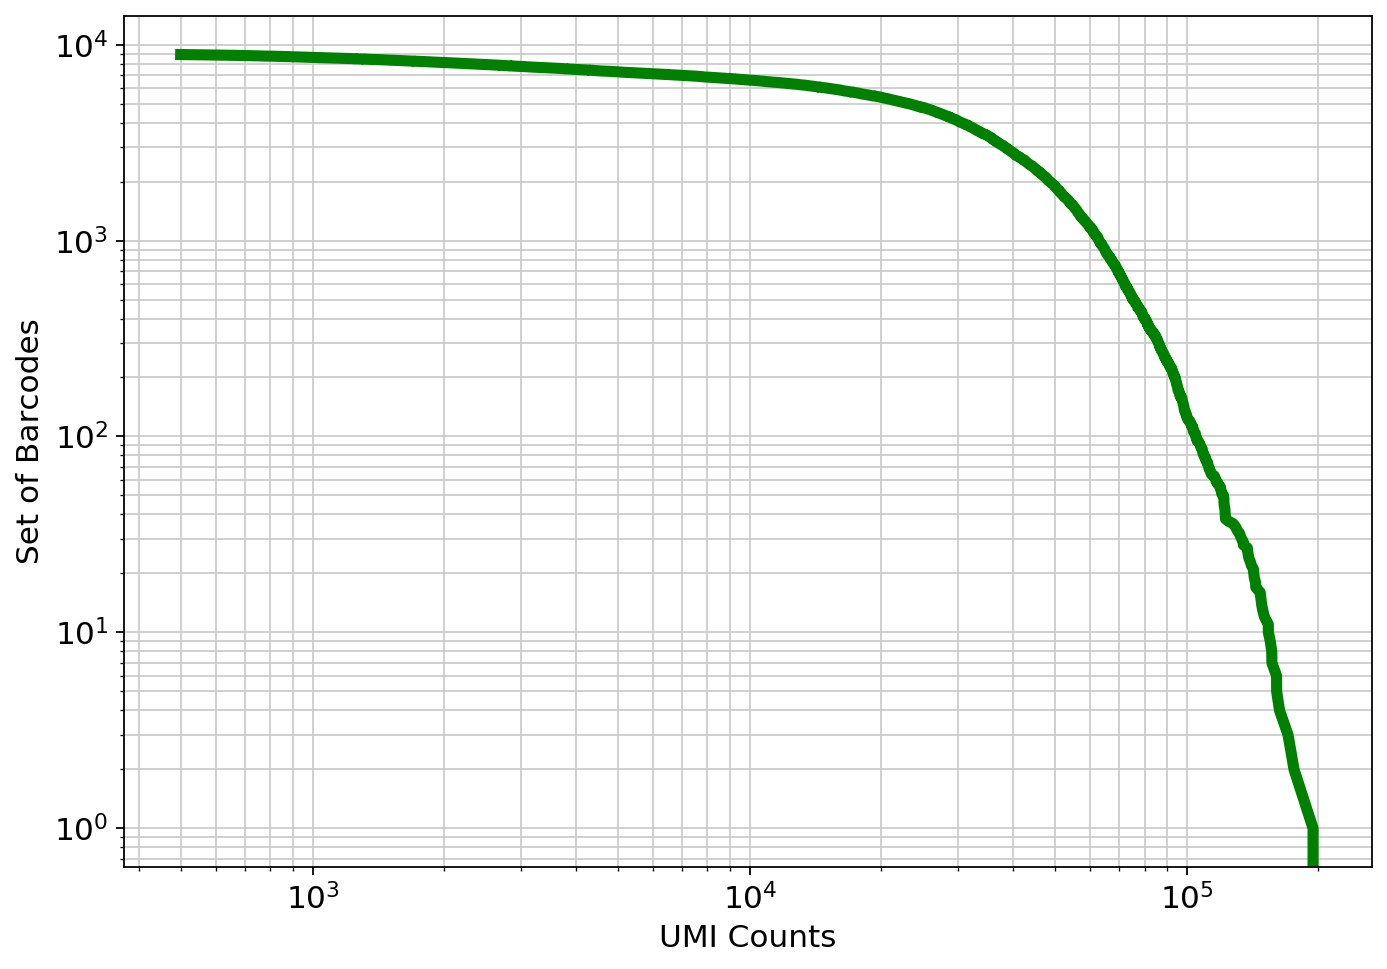

In [167]:
# knee plot
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]
fig, ax = plt.subplots(figsize=(10, 7))

ax.loglog(knee, range(len(knee)),linewidth=5, color="g")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

The knee plot looks like this because the cells were already filtered using cellranger

In [168]:
sc.pp.calculate_qc_metrics(adata)

(                      n_genes_by_counts  log1p_n_genes_by_counts  \
 index                                                              
 AAACCCACACCATAAC-0-0               4299                 8.366370   
 AAACCCATCGTCGGGT-0-0               5623                 8.634798   
 AAACGAAAGTAGTGCG-0-0               6179                 8.729074   
 AAACGCTCACCGTGGT-0-0               5815                 8.668368   
 AAACGCTGTGACTATC-0-0               6061                 8.709795   
 ...                                 ...                      ...   
 TTTGGAGTCTCTGACC-1                 6854                 8.832734   
 TTTGGTTAGGAGTATT-1                 8790                 9.081484   
 TTTGGTTCATCGTGGC-1                 5693                 8.647168   
 TTTGGTTGTCTGGTTA-1                 6746                 8.816853   
 TTTGGTTTCGACGAGA-1                  200                 5.303305   
 
                       total_counts  log1p_total_counts  \
 index                                    

In [169]:
mito_genes = adata.var_names.str.startswith('mt-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

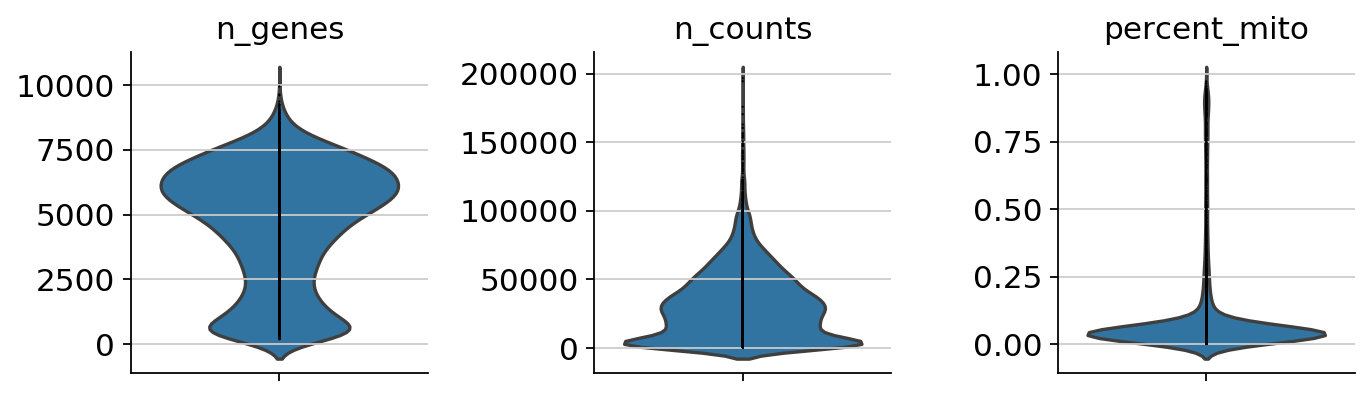

In [170]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter = 0,multi_panel=True)

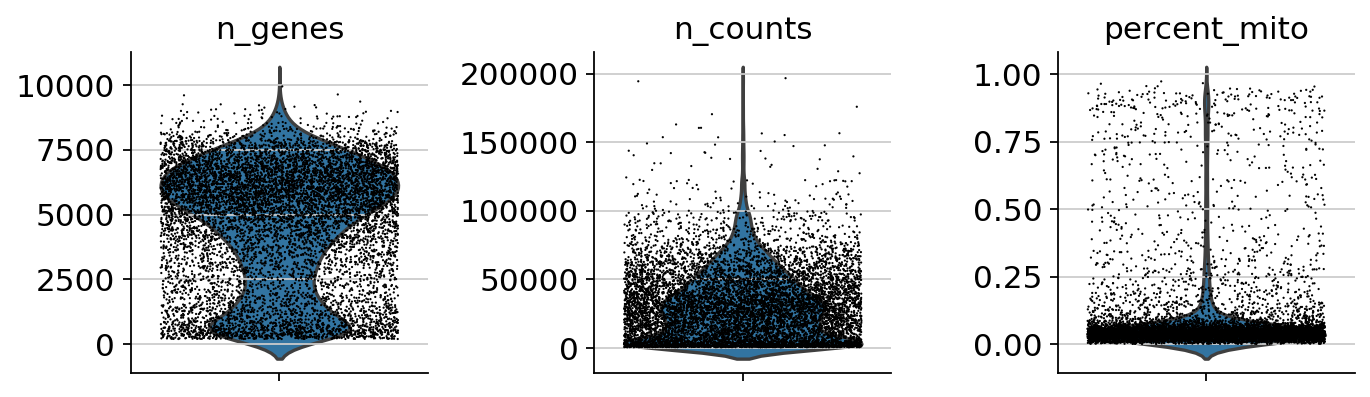

In [171]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter = 0.4, multi_panel=True)

In [149]:
adata[adata.obs.percent_mito < 0.05, :]

View of AnnData object with n_obs × n_vars = 5633 × 20605 
    obs: 'batch', 'cellLabel', 'mouse', 'media', 'day', 'n_genes', 'percent_mito', 'n_counts'
    var: 'geneId', 'n_cells'

In [89]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

Normalizing counts per cell.
    finished (0:00:00):normalized adata.X
computing neighbors
    using 'X_pca' with n_pcs = 40


/home/gaurav/.local/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../home/gaurav/.local/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


    finished (0:00:05)


In [90]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:30)


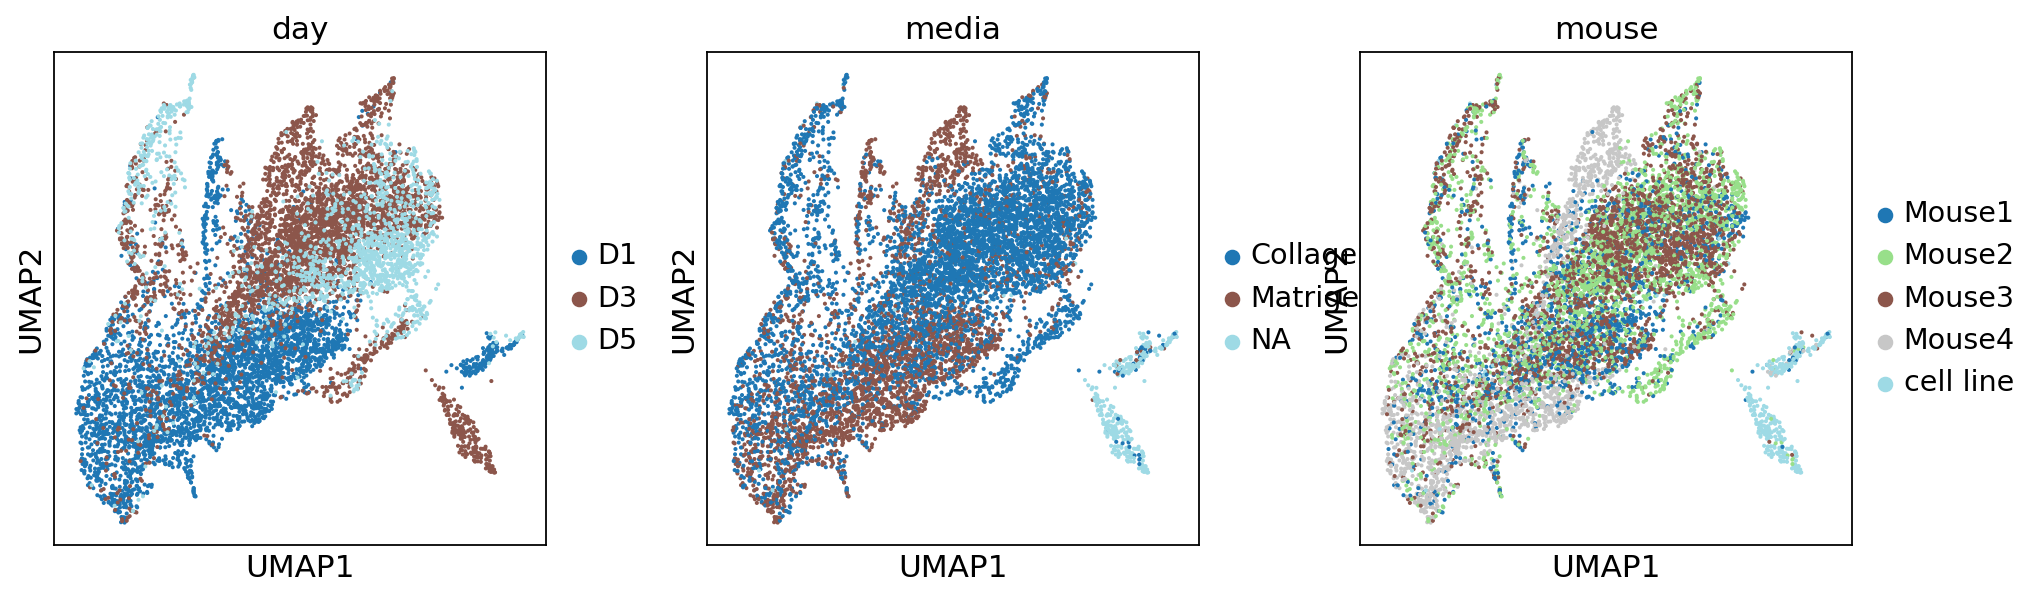

In [93]:
sc.pl.umap(adata,color=['day','media','mouse'],palette='tab20')

In [146]:
adata = adata[adata.obs.percent_mito < 0.10, :]
adata

View of AnnData object with n_obs × n_vars = 7620 × 20605 
    obs: 'batch', 'cellLabel', 'mouse', 'media', 'day', 'n_genes', 'percent_mito', 'n_counts'
    var: 'geneId', 'n_cells'

In [66]:
adata.write_h5ad('rawCleanadata.h5ad')

In [173]:
adata = ad.read_h5ad('rawCleanadata.h5ad')
adata

AnnData object with n_obs × n_vars = 7620 × 20605 
    obs: 'batch', 'cellLabel', 'mouse', 'media', 'day', 'n_genes', 'percent_mito', 'n_counts'
    var: 'geneId', 'n_cells'

In [174]:
scp.io.mmwrite('data/dataMatrixClean.mtx',adata.X)
adata.obs.to_csv('data/obsClean.csv')
adata.var.to_csv('data/varClean.csv')

Might include a doublet detection algorithm here or remove cells with genes > 9000 or counnts > 120k

In [85]:
adata[adata.obs.n_genes < 9000,:]

View of AnnData object with n_obs × n_vars = 7604 × 20605 
    obs: 'batch', 'cellLabel', 'mouse', 'media', 'day', 'n_genes', 'percent_mito', 'n_counts'
    var: 'geneId', 'n_cells'
    uns: 'pca', 'neighbors', 'day_colors', 'mouse_colors', 'media_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [84]:
adata[adata.obs.n_counts < 150000, :]

View of AnnData object with n_obs × n_vars = 7607 × 20605 
    obs: 'batch', 'cellLabel', 'mouse', 'media', 'day', 'n_genes', 'percent_mito', 'n_counts'
    var: 'geneId', 'n_cells'
    uns: 'pca', 'neighbors', 'day_colors', 'mouse_colors', 'media_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [137]:
adata = ad.read_h5ad('rawCleanadata.h5ad')
adata

AnnData object with n_obs × n_vars = 7620 × 20605 
    obs: 'batch', 'cellLabel', 'mouse', 'media', 'day', 'n_genes', 'percent_mito', 'n_counts'
    var: 'geneId', 'n_cells'

normalizing by total count per cell
    finished (0:00:03): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


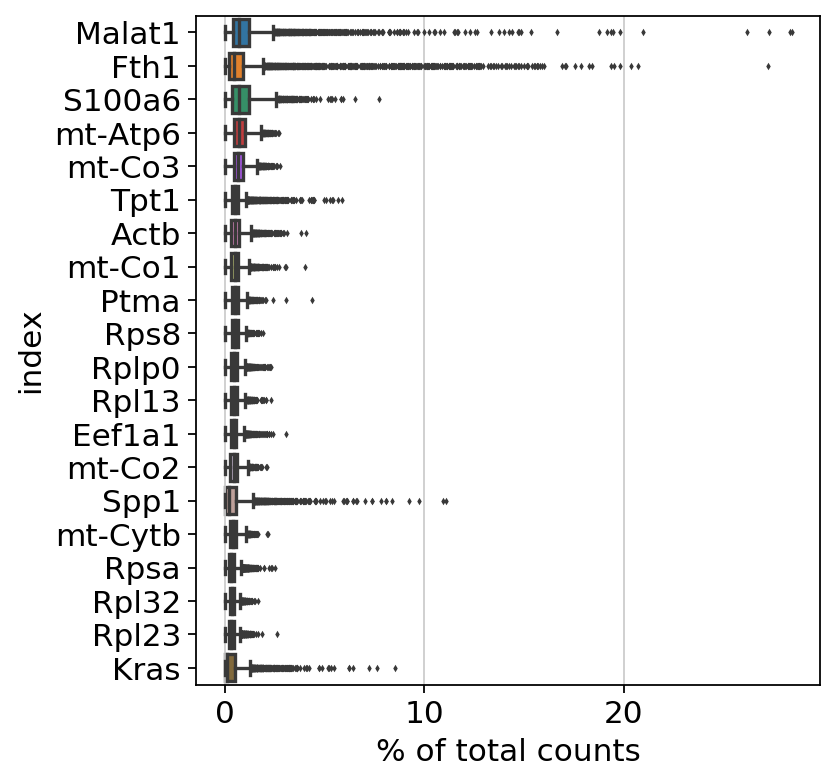

In [138]:
sc.pl.highest_expr_genes(adata, n_top=20, )